In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random

Using TensorFlow backend.


In [2]:
# Randomly select a defined number of image paires from a given dataset
def get_left_min_image_combinations(number_image_pairs_selected, image_data, image_labels):
    
    num_images_total = len(image_labels)
    
    image_combination_data = []
    image_combination_labels = []
    
    for i in range(number_image_pairs_selected):
        
        # Draw two image indices from a uniform random distribution
        random_index_A = random.randint(0, num_images_total-1)
        random_index_B = random.randint(0, num_images_total-1)
        
        # Randomly choose two images from the dataset
        image_A = image_data[random_index_A]
        image_B = image_data[random_index_B]
        
        # Merge images TODO: this could be a function with several options
        combined_images = np.hstack((image_A, image_B))
        
        # Find the minimum between the two labels
        label_A = image_labels[random_index_A]
        label_B = image_labels[random_index_B]
        minimum_label = min(label_A, label_B)
        
        if label_A <= label_B:
            # Merge images TODO: this could be a function with several options
            combined_images = np.hstack((image_A, image_B))
        elif label_A > label_B: 
            # Merge images TODO: this could be a function with several options
            combined_images = np.hstack((image_B, image_A))
        # Here we want to exclude the images where they are the same on both sides
            
   
        # Append newly generated image combination and minimum label to list
        image_combination_data.append(combined_images)
        image_combination_labels.append(minimum_label)
        
    # Convert image data and labels lists to numpy arrays
    image_combination_data = np.array(image_combination_data)
    image_combination_labels = np.array(image_combination_labels)
    
    return image_combination_data, image_combination_labels

In [3]:
# Randomly select a defined number of image paires from a given dataset
def get_right_min_image_combinations(number_image_pairs_selected, image_data, image_labels):
    
    num_images_total = len(image_labels)
    
    image_combination_data = []
    image_combination_labels = []
    
    for i in range(number_image_pairs_selected):
        
        # Draw two image indices from a uniform random distribution
        random_index_A = random.randint(0, num_images_total-1)
        random_index_B = random.randint(0, num_images_total-1)
        
        # Randomly choose two images from the dataset
        image_A = image_data[random_index_A]
        image_B = image_data[random_index_B]
        
        # Merge images TODO: this could be a function with several options
        combined_images = np.hstack((image_A, image_B))
        
        # Find the minimum between the two labels
        label_A = image_labels[random_index_A]
        label_B = image_labels[random_index_B]
        minimum_label = min(label_A, label_B)
        
        if label_A < label_B:
            # Merge images TODO: this could be a function with several options
            combined_images = np.hstack((image_B, image_A))
        elif label_A > label_B: 
            # Merge images TODO: this could be a function with several options
            combined_images = np.hstack((image_A, image_B))
        # Here we want to exclude the images where they are the same on both sides
            
   
        # Append newly generated image combination and minimum label to list
        image_combination_data.append(combined_images)
        image_combination_labels.append(minimum_label)
        
    # Convert image data and labels lists to numpy arrays
    image_combination_data = np.array(image_combination_data)
    image_combination_labels = np.array(image_combination_labels)
    
    return image_combination_data, image_combination_labels

In [4]:
# Load data and split into training and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
# Split training set further into training and validation sets
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

In [6]:
combo_train_X, combo_train_y = get_left_min_image_combinations(40000, X_train, y_train)
combo_val_X, combo_val_y = get_right_min_image_combinations(20000, X_val, y_val)

In [7]:
# Reshape the data so they can be fed into the network, one-hot-encode the labels

train_images = combo_train_X.reshape((combo_train_X.shape[0], 28, 56, 1))
train_images = train_images/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28, 56, 1))
val_images = val_images/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

In [12]:
# Experiment parameters

num_epochs = 20
num_iterations = 5

In [13]:
# Model architecture
def build_CNN():

    # Convolutional NN
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,56,1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    # Adding a NN Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(10, activation = 'softmax'))

    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [14]:
CNN_model = build_CNN()
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [11]:
# Fit model
CNN_accuracy = []

for i in range(num_iterations):

    CNN_model.fit(train_images, 
              train_labels, 
              epochs = num_epochs, 
              batch_size = 64)
    
    # Print loss, mae and accuracy
    CNN_eval_model = CNN_model.evaluate(val_images, val_labels)
    CNN_accuracy.append(CNN_eval_model[1])

Epoch 1/5
625/625 [==============================] - 28s 44ms/step - loss: 0.1787 - accuracy: 0.9444 - mae: 0.0172
Epoch 2/5
625/625 [==============================] - 51s 82ms/step - loss: 0.0370 - accuracy: 0.9887 - mae: 0.0035
Epoch 3/5
625/625 [==============================] - 38s 61ms/step - loss: 0.0198 - accuracy: 0.9937 - mae: 0.0019
Epoch 4/5
625/625 [==============================] - 36s 57ms/step - loss: 0.0137 - accuracy: 0.9956 - mae: 0.0012
Epoch 5/5
625/625 [==============================] - 3s 5ms/step - loss: 20.8963 - accuracy: 0.1042 - mae: 0.1790
Epoch 1/5
625/625 [==============================] - 36s 58ms/step - loss: 0.0070 - accuracy: 0.9979 - mae: 5.9058e-04
Epoch 2/5
625/625 [==============================] - 47s 75ms/step - loss: 0.0048 - accuracy: 0.9984 - mae: 4.1264e-04
Epoch 3/5
625/625 [==============================] - 75s 120ms/step - loss: 0.0029 - accuracy: 0.9989 - mae: 2.7838e-04
Epoch 4/5
625/625 [==============================] - 42s 68ms/step -

In [14]:
CNN_model = build_CNN()
CNN_model.fit(train_images, 
              train_labels, 
              epochs = num_epochs, 
              batch_size = 64)

 # Print loss, mae and accuracy
CNN_eval_model = CNN_model.evaluate(val_images, val_labels)
CNN_accuracy.append(CNN_eval_model[1])
CNN_eval_model

Epoch 1/5
625/625 [==============================] - 27s 43ms/step - loss: 0.2125 - accuracy: 0.9336 - mae: 0.0202
Epoch 2/5
625/625 [==============================] - 32s 52ms/step - loss: 0.0428 - accuracy: 0.9865 - mae: 0.0041
Epoch 3/5
625/625 [==============================] - 30s 47ms/step - loss: 0.0259 - accuracy: 0.9919 - mae: 0.0024
Epoch 4/5
625/625 [==============================] - 30s 48ms/step - loss: 0.0161 - accuracy: 0.9949 - mae: 0.0015
Epoch 5/5
625/625 [==============================] - 3s 5ms/step - loss: 16.8169 - accuracy: 0.1104 - mae: 0.1777


In [16]:
CNN_eval_model

[16.816865921020508, 0.11044999957084656, 0.17765407264232635]

In [15]:
# Model architecture
def build_DNN():

    # Convolutional NN
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,56,1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    # Adding a NN Classifier
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(10, activation = 'softmax'))

    # Compile model
    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [16]:
DNN_model = build_DNN()
DNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)             

In [17]:
# Fit model
DNN_accuracy = []

for i in range(num_iterations):

    DNN_model.fit(train_images, 
              train_labels, 
              epochs = num_epochs, 
              batch_size = 64)
    
    # Print loss, mae and accuracy
    DNN_eval_model = DNN_model.evaluate(val_images, val_labels)
    DNN_accuracy.append(DNN_eval_model[1])

Epoch 1/20
625/625 [==============================] - 35s 54ms/step - loss: 0.2318 - accuracy: 0.9287 - mae: 0.0219
Epoch 2/20
625/625 [==============================] - 33s 53ms/step - loss: 0.0586 - accuracy: 0.9813 - mae: 0.0056
Epoch 3/20
625/625 [==============================] - 33s 53ms/step - loss: 0.0413 - accuracy: 0.9869 - mae: 0.0038
Epoch 4/20
625/625 [==============================] - 34s 54ms/step - loss: 0.0296 - accuracy: 0.9908 - mae: 0.0027
Epoch 5/20
625/625 [==============================] - 33s 53ms/step - loss: 0.0244 - accuracy: 0.9919 - mae: 0.0022
Epoch 6/20
625/625 [==============================] - 34s 54ms/step - loss: 0.0199 - accuracy: 0.9934 - mae: 0.0018
Epoch 7/20
625/625 [==============================] - 35s 56ms/step - loss: 0.0176 - accuracy: 0.9943 - mae: 0.0015
Epoch 8/20
625/625 [==============================] - 34s 54ms/step - loss: 0.0145 - accuracy: 0.9955 - mae: 0.0012
Epoch 9/20
625/625 [==============================] - 35s 56ms/step - lo

In [18]:
# Print loss, mae and accuracy
DNN_eval_model = DNN_model.evaluate(val_images, val_labels)
DNN_eval_model

625/625 [==============================] - 3s 4ms/step - loss: 97.6995 - accuracy: 0.1017 - mae: 0.1797


[97.6994857788086, 0.10170000046491623, 0.17965711653232574]

In [19]:
# Interesting that the DNN is slightly better than the CNN at this task

<BarContainer object of 2 artists>

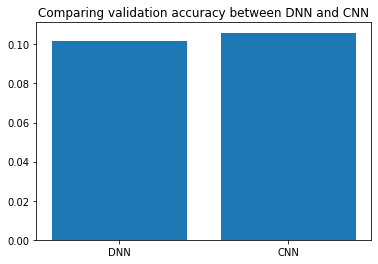

In [21]:
# PLotting
plt.title('Comparing validation accuracy between DNN and CNN')
plt.bar(['DNN','CNN'], [DNN_eval_model[1],CNN_eval_model[1]])